# MSER and Clustering

We are trying here to exploit the results of an MSER to di clustering.

In [311]:
from skimage.io import imread
from skimage import img_as_ubyte
import matplotlib.pyplot as plt
import numpy as np
import cv2

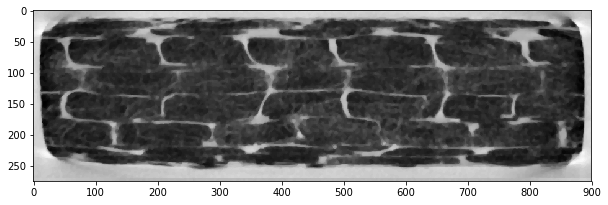

In [312]:
#Image importation

volume_source = imread("Denoised_Equalized_Volume.tif")

from skimage import img_as_float
volume_source = img_as_float(volume_source)
img_source = 1-volume_source[volume_source.shape[0]//2, :, :]
img_source = img_source
plt.figure(figsize=(10, 10))
plt.imshow(img_source, cmap=plt.get_cmap('gray'))

## MSER

In [313]:
def image_tresholding(img, treshold = 0.5):
    res = img_as_float(img>treshold)
    return res

def compo_linking(n1, labels1, n2, labels2):
    res = np.zeros((n2, n1))
    row, col = labels2.shape
    for i in range(row):
        for j in range(col):
            res[labels2[i][j]][labels1[i][j]] = 1
    return res

def area_growth_rate(n2, labels1, labels2, label_link, former_rate1 = []):
    rate = []
    former_rate2 = []
    if len(former_rate1) == 0:
        former_rate1 = np.zeros(label_link.shape[1])
    for compo2 in range(n2):
        area2 = sum(sum(labels2 == compo2))
        area1 = 0
        former_rate2.append(None)
        for i in range(1, label_link.shape[1]):
            if label_link[compo2][i]:
                area1 += sum(sum(labels1 == i))
                if not(former_rate1[i] is None):
                    if former_rate2[compo2] is None:
                        former_rate2[compo2] = 0
                    former_rate2[compo2] += sum(sum(labels1 == i)) * former_rate1[i]
        if (area1 == 0):
            rate.append(None)
            former_rate2[compo2] = None
        else:
            if not(former_rate2[compo2] is None):
                former_rate2[compo2] = former_rate2[compo2]/area1
            else:
                former_rate2[compo2] = None
            if (area2 != 0):
                rate.append((area2-area1)/area2)
            else:
                rate.append(None)
    return rate, former_rate2

def add_compo(compo, labels, tresh_img):
    #We add the convex envelop by row
    #for each row, we look for the max and min colum of the component, fill the interrior with 255 and add 0 outside
    res = tresh_img
    row, col = labels.shape
    compo_img = (labels == compo)
    compo_img = img_as_ubyte(compo_img)
    first_row = False
    fill_first_row = False
    former_min_col = res.shape[1]
    former_max_col = 0
    for i in range(row):
        min_col = 0
        max_col = 0
        first_col = False
        for j in range(col):
            if compo_img[i][j] == 255:
                if first_row == False:
                    first_row = True
                    fill_first_row = True
                if first_col == False:
                    min_col = j
                    first_col = True
                max_col = j
        res[i][min_col:max_col] = 255
        if fill_first_row:
            fill_first_row = False
            if i>0:
                res[i-1][min_col:max_col] = 0
                if min_col > 0:
                    res[i-1][min_col-1] = 0
                if max_col < (col-1):
                    res[i-1][max_col+1] = 0
        if i>0:
            if min_col <= former_min_col:
                res[i-1][(min_col-1):(former_min_col+1)] = 0
            if max_col >= former_max_col:
                res[i-1][(former_max_col-1):(max_col+1)] = 0
        if min_col > 0:
            res[i][min_col-1] = 0
        if max_col < (col-1):
            res[i][max_col+1] = 0
        if i<(row-1):
            res[i+1][min_col:max_col] = 0
            if min_col > 0:
                res[i+1][min_col-1] = 0
            if max_col < (col-1):
                res[i+1][max_col+1] = 0
        former_min_col = min_col
        former_max_col = max_col
    return res

def remove_compo(compo, labels, img):
    row, col = labels.shape
    res = img
    for i in range(row):
        for j in range(col):
            if (labels[i,j] == compo):
                res[i,j] = 255
    return res

def compo_surface(compo, labels):
    res = sum(sum(labels == compo))
    return res

def MSER_area_growth_2(img_source, min_tresh, max_tresh, tresh_step, min_area):
    #initialisation
    tresh = min_tresh
    tresh_image = img_as_ubyte(1-image_tresholding(img_source, tresh))
    label_num1, labels1 = cv2.connectedComponents(tresh_image)
    growth_rate1 = []
    stopped_compo1 = []
    #background__to_add = np.zeros(img_source.shape)
    it = 0
    row, col = img_source.shape
    background = np.zeros(img_source.shape)
    if label_num1 > 0:
        for i in range(0, label_num1):
            growth_rate1.append(None)
            stopped_compo1.append(False)
    while tresh <= max_tresh:
        #iterations
        it+=1
        print(it)
        #tresholding
        tresh = tresh + tresh_step
        tresh_image = img_as_ubyte(1-image_tresholding(img_source, tresh))
        #add the fixed components to the tresholding
        if label_num1 > 0:
            for i in range(1, label_num1):
                if stopped_compo1[i]:
                    if compo_surface(i, labels1) < min_area:
                        background = remove_compo(i, labels1, background)
                    else:
                        tresh_image = add_compo(i, labels1, tresh_image)
        for i in range(row):
            for j in range(col):
                if background[i, j]:
                    tresh_image[i,j] = 0.
        #We find the connected components and link them
        label_num2, labels2 = cv2.connectedComponents(tresh_image)
        label_link = compo_linking(label_num1, labels1, label_num2, labels2)
        #We calculate the growth rate
        growth_rate2, former_rate = area_growth_rate(label_num2, labels1, labels2, label_link, growth_rate1)
        #if it == 1:
            #print(growth_rate1)
            #print(former_rate)
        #We stop the growth if the component was stopped before or if the growth rate is lower
        stopped_compo2 = []
        for compo2 in range(label_num2):
            stopped = False
            for i in range(1, label_num1):
                if (label_link[compo2][i]) and (stopped_compo1[i]):
                    stopped = True
            if (not growth_rate2[compo2] is None) and (not former_rate[compo2] is None) and growth_rate2[compo2] > former_rate[compo2]:
                stopped = True
            #if (not growth_rate2[compo2] is None) and (not former_rate[compo2] is None) and growth_rate2[compo2] < 0.1:
            #    stopped = True
            stopped_compo2.append(stopped)
            
        #We actualize the variables
        label_num1 = label_num2
        print(label_num1)
        labels1 = labels2
        growth_rate1 = growth_rate2
        stopped_compo1 = stopped_compo2
        print(sum(stopped_compo1))
    return label_num1, labels1, stopped_compo1, background

In [314]:
min_area = 1000
n, labels, stopped, background = MSER_area_growth_2(img_source, min_tresh = 0.05, max_tresh = 0.5, tresh_step = 0.05, min_area = min_area)
n

D:\Program Files\Anaconda3\lib\site-packages\skimage\util\dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


1
69
0
2
281
3
3
161
11
4
164
11
5
164
14
6
194
17
7
235
26
8
263
20
9
224
36
10
285
26


285

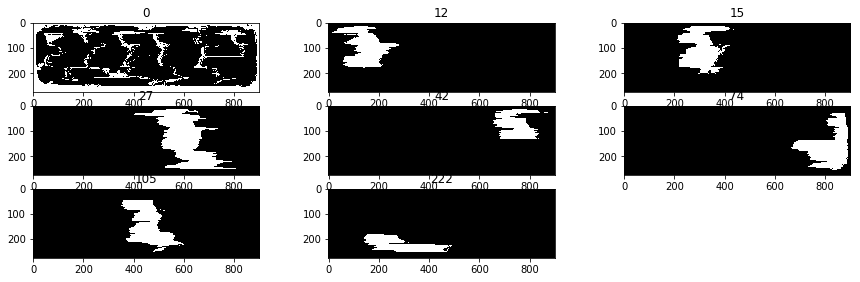

In [315]:
#the stopped component
min_area = 1000
plt.figure(figsize=(15,15))
i = 0
index = 0
while i<30:
    if index>n:
        break
    if (stopped[(index-1)]) and (compo_surface(index-1, labels)>=min_area):
        i +=1
        plt.subplot(10,3,i)
        plt.title(index-1)
        plt.imshow(labels == (index-1), cmap='gray')
    index += 1

14536

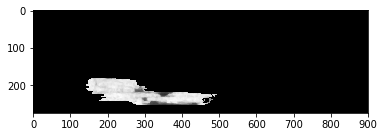

In [461]:
test_img = np.zeros(img_source.shape)
row, col = img_source.shape
for i in range(row):
    for j in range(col):
        if labels[i][j] == 222:
            test_img[i][j] = 1-img_source[i][j]
plt.imshow(test_img, cmap=plt.get_cmap('gray'))
compo_surface(42, labels)

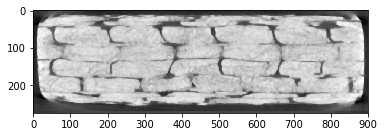

In [317]:
plt.imshow(255-img_source, cmap=plt.get_cmap('gray'))

# Clustering


## sklearn K-mean

For the component 12, we first try a k-mean clustering, with the coordinates of the points, weighting with pisel intensity.

In [318]:
from sklearn.cluster import k_means

In [491]:
#Database creation
clump_n = 12
X = []
X_weights = []
row, col = img_source.shape
for i in range(row):
    for j in range(col):
        if labels[i][j] == clump_n:
            X.append([i, j/3])
            X_weights.append(1-img_source[i][j])

In [479]:
#Clustering
cluster_num = 4
kmeans= k_means(X = X, n_clusters = cluster_num)
kmeans[2]

2866038.686802097

In [454]:
len(X)

14536

In [480]:
km_res = np.zeros(img_source.shape)
for pixel in range(len(X)):
    km_res[X[pixel][0], int(X[pixel][1]*3)] = kmeans[1][pixel] + 1

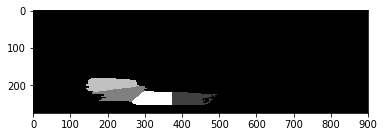

In [481]:
plt.imshow(km_res, cmap=plt.get_cmap('gray'))

To take account to the elongated form of the desired clusters, we have artificially distorted them.

In [469]:
cluster_num = 4
num = []
inertia = []
for i in range(1,10):
    kmeans= k_means(X = X, n_clusters = i)
    num.append(i)
    inertia.append(kmeans[2])

In [456]:
inertia


[21010449.99228735,
 7314487.998492508,
 4533785.756567355,
 3678065.197720891,
 2887335.430113367,
 2288142.900527713,
 1861842.304937531,
 1644592.19925655,
 1452510.4814942498]

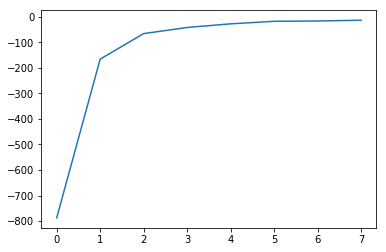

In [470]:
plt.plot(np.diff(inertia)/len(X))

-0.2012730436033411

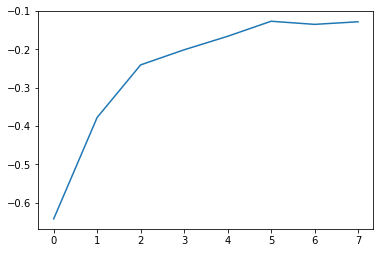

In [478]:
test = np.zeros(8)
for i in range(8):
    test[i] = np.diff(inertia)[i]/inertia[i]
plt.plot(test)
test[3]

# K means with weights

In [483]:
from numpy.random import randint 

def dist_1(X, Y):
    return((X[0]-Y[0])**2 + (X[1]-Y[1])**2)

def km_1(X, weights, n_cluster, max_it = 300):
    #Initialisation
    c_label = np.zeros(len(X))
    c_last_label = np.zeros(len(X))
    c_norm = np.zeros(n_cluster)
    c_centroid = np.zeros((n_cluster, 2))
    c_init = randint(0, len(X)+1, n_cluster)
    for i in range(n_cluster):
        c_centroid[i][0] = X[c_init[i]][0]
        c_centroid[i][1] = X[c_init[i]][1]
    for i in range(len(X)):
        #New cluster
        dist = np.zeros(n_cluster)
        for j in range(n_cluster):
            dist[j] = dist_1(X[i], c_centroid[j])
        c_label[i] = np.argsort(dist)[0]
    for i in range(len(X)):
        c_norm[int(c_label[i])] += weights[i]
        c_centroid[int(c_label[i])][0] += weights[i] * X[i][0]
        c_centroid[int(c_label[i])][1] += weights[i] * X[i][1]
    for i in range(n_cluster):
        c_centroid[i][0] = c_centroid[i][0] / c_norm[i]
        c_centroid[i][1] = c_centroid[i][1] / c_norm[i]
    print(c_centroid)
    stop = False
    it = 0
    #Iterations
    while not stop:
        c_last_label = np.copy(c_label)
        it += 1
        if it%10 == 0:
            print(it)
        for i in range(len(X)):
            #New cluster
            dist = np.zeros(n_cluster)
            for j in range(n_cluster):
                dist[j] = dist_1(X[i], c_centroid[j])
            c_label[i] = np.argsort(dist)[0]
        #New centroids
        c_norm = np.zeros(n_cluster)
        c_centroid = np.zeros((n_cluster, 2))
        for i in range(len(X)):
            c_norm[int(c_label[i])] += weights[i]
            c_centroid[int(c_label[i])][0] += weights[i] * X[i][0]
            c_centroid[int(c_label[i])][1] += weights[i] * X[i][1]
        for i in range(n_cluster):
            c_centroid[i][0] = c_centroid[i][0] / c_norm[i]
            c_centroid[i][1] = c_centroid[i][1] / c_norm[i]
        if (np.array_equal(c_label, c_last_label)) or it > max_it:
            stop = True
    entropy = 0
    for i in range(len(X)):
        entropy += dist_1(X[i], c_centroid[int(c_label[i])])
    return c_label, c_centroid, it, entropy

In [484]:
kmeans, km_centroids, it, entropy = km_1(X, X_weights, 4, 300)

[[191.95707875  75.99106666]
 [220.576383    78.61632832]
 [235.41067493 123.78551787]
 [200.81323311  56.69005426]]
10


In [408]:
test = np.zeros(10)
for i in range(1,10):
    kmeans, km_centroids, it, entropy = km_1(X, X_weights, i, 300)
    test[i] = entropy

10
20
30
10
20
10
20
30
10
20
30
10
20
10
20
30
40
50
60
10
20
10
20
30
40
50
60


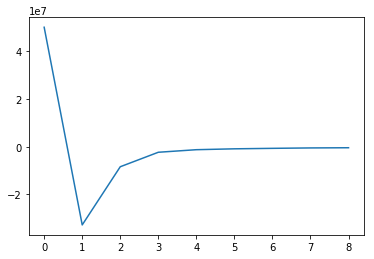

In [421]:
plt.plot(np.diff(test))

In [403]:
km_res = np.zeros(img_source.shape)
for pixel in range(len(X)):
    km_res[int(X[pixel][0]), int(X[pixel][1]*3)] = kmeans[pixel] + 1

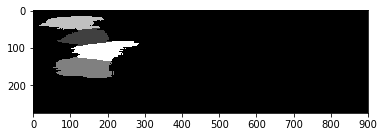

In [404]:
plt.imshow(km_res, cmap=plt.get_cmap('gray'))

# With a custom L1 distance

In [482]:
abs(-1)

1

In [499]:
from numpy.random import randint 

def dist_1(X, Y):
    x_dist = abs(X[0]-Y[0])
    y_dist = abs(X[1]-Y[1])
    return min(x_dist/3, y_dist)

def km_1(X, weights, n_cluster, max_it = 300):
    #Initialisation
    c_label = np.zeros(len(X))
    c_last_label = np.zeros(len(X))
    c_norm = np.zeros(n_cluster)
    c_centroid = np.zeros((n_cluster, 2))
    c_init = randint(0, len(X)+1, n_cluster)
    for i in range(n_cluster):
        c_centroid[i][0] = X[c_init[i]][0]
        c_centroid[i][1] = X[c_init[i]][1]
    for i in range(len(X)):
        #New cluster
        dist = np.zeros(n_cluster)
        for j in range(n_cluster):
            dist[j] = dist_1(X[i], c_centroid[j])
        c_label[i] = np.argsort(dist)[0]
    for i in range(len(X)):
        c_norm[int(c_label[i])] += weights[i]
        c_centroid[int(c_label[i])][0] += weights[i] * X[i][0]
        c_centroid[int(c_label[i])][1] += weights[i] * X[i][1]
    for i in range(n_cluster):
        c_centroid[i][0] = c_centroid[i][0] / c_norm[i]
        c_centroid[i][1] = c_centroid[i][1] / c_norm[i]
    stop = False
    it = 0
    #Iterations
    while not stop:
        c_last_label = np.copy(c_label)
        it += 1
        if it%10 == 0:
            print(it)
        for i in range(len(X)):
            #New cluster
            dist = np.zeros(n_cluster)
            for j in range(n_cluster):
                dist[j] = dist_1(X[i], c_centroid[j])
            c_label[i] = np.argsort(dist)[0]
        #New centroids
        c_norm = np.zeros(n_cluster)
        c_centroid = np.zeros((n_cluster, 2))
        for i in range(len(X)):
            c_norm[int(c_label[i])] += weights[i]
            c_centroid[int(c_label[i])][0] += weights[i] * X[i][0]
            c_centroid[int(c_label[i])][1] += weights[i] * X[i][1]
        for i in range(n_cluster):
            c_centroid[i][0] = c_centroid[i][0] / c_norm[i]
            c_centroid[i][1] = c_centroid[i][1] / c_norm[i]
        if (np.array_equal(c_label, c_last_label)) or it > max_it:
            stop = True
    entropy = 0
    for i in range(len(X)):
        entropy += dist_1(X[i], c_centroid[int(c_label[i])])
    return c_label, c_centroid, it, entropy

In [501]:
kmeans, km_centroids, it, entropy = km_1(X, X_weights, 4, 50)

10
20
30
40
50


In [502]:
km_res = np.zeros(img_source.shape)
for pixel in range(len(X)):
    km_res[int(X[pixel][0]), int(X[pixel][1]*3)] = kmeans[pixel] + 1
it

51

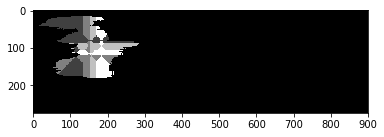

In [503]:
plt.imshow(km_res, cmap=plt.get_cmap('gray'))